<h2> In this notebook, we explore backtesting and assumptions testing

<h5>

1. Backtesting: for regulatory credibility and answers "Does my VaR number actually protect me from losses the way it claims?"
- Kupiec: Do we exceed VaR too often?
- Christoffersen: Do breaches come together?
- Basel (Traffic light): Regulatory requirement.
<br><br>

2. Assumption testing: for model risk and limitations, and answers "Are the statistical assumptions behind my VaR reasonable?"
- Normality tests (Jaque-Bera): Are losses heavier than normal?
- Autocorrelation (ACF-plot): Are returns predictable?
- Volatility clustering (ARCH test)P Do risk cluster in crises?

<br><br>
- p-value = probability of obtaining results as extreme as the observed results, assuming mull hypothesis is true. low p-value = data is unlikely if h0 were to be true.

In [8]:
import pandas as pd
import numpy as np
from scipy.stats import norm, chi2

In [11]:
returns = pd.read_csv("../data/portfolio_log_returns.csv", index_col=0, parse_dates=True)
print(f"\nPortfolio returns head:\n{returns.head()}")

VaR_series = pd.read_csv("../data/var_mc_95.csv", index_col=0, parse_dates=True)
print(f"\nVaR series head:\n{VaR_series.head()}")


Portfolio returns head:
            port_log
DATE                
2016-01-26  0.008944
2016-01-27 -0.005780
2016-01-28  0.006425
2016-01-29  0.010268
2016-02-01  0.001797

VaR series head:
            VaR_MC_95
DATE                 
2017-01-26  -0.007791
2017-01-27  -0.007850
2017-01-30  -0.007807
2017-01-31  -0.007859
2017-02-01  -0.007840


In [12]:
# Merge on index to ensure alignment
data = pd.concat([returns, VaR_series], axis=1, join='inner').dropna()
data.head()

,port_log,VaR_MC_95
DATE,,
2017-01-26,-0.003169,-0.007791
2017-01-27,0.000229,-0.007850
2017-01-30,-0.003953,-0.007807
2017-01-31,0.003675,-0.007859
2017-02-01,-0.001157,-0.007840


In [17]:
# Declaring violations
# If actual loss (port_log) > VaR estimate (VaR_MC_95), it's a violation
violations = (data['port_log'] < data['VaR_MC_95']).astype(int)
violations.describe()

count    1973.000000
mean        0.058287
std         0.234345
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
dtype: float64

<h2> Backtesting

<h5>

1. Kupiec POF test
2. Christoffersen independence test
3. Basel traffic-light framework

<h3> Kupiec Proportion of Failures test 

- Tests if violations occur as often as expected: At 95% VaR, the expected violation rate ~=5%

In [ ]:
def kupiec_pof_test(violations, alpha=0.05):
    T = len(violations) # total number of backtesting days
    x = violations.sum() # number of violations
    p = alpha # model claimed violation probability

    likelihood_ratio = -2 * (
        (x * np.log(p) + (T - x) * np.log(1 - p)) - # likelihood under the model (null) // h0: model is correct and violation probability is alpha
        (x * np.log(x / T) + (T - x) * np.log(1 - x / T)) # likelihood under observed data (alternative) // h1: model is not correct
    )
    
    # if model is correct, likelihoods should be close, so LR should be small

    p_value = 1 - chi2.cdf(likelihood_ratio, df=1)
    return likelihood_ratio, p_value

In [19]:
kupiec = kupiec_pof_test(violations, alpha=0.05)
print(f"Kupiec test results: Likelihood Ratio = {kupiec[0]:.4f}, p-value = {kupiec[1]:.4f}")

Kupiec test results: Likelihood Ratio = 2.7144, p-value = 0.0994


<h5> Kupiec test results: Likelihood Ratio = 2.7144, p-value = 0.0994

- Likelihood ratio of 2.7144 suggest that the number of violations is reasonably close to the model's expected 5% rate

- p-value = 0.0994 > 0.05. Fail to reject h0 and the model is consistent with the data. If p-value < 0.05 we reject h0 and conclude that the model is likely misestimating risk.


<h3> Christoffersen Independence Test

- Tests if violations are independent or do they cluster?
- If there is clustering, it means that VaR misses volatility regimes

In [ ]:
# if violations are independent, 
# then probability of violation given that the previous day was a violation 
# hould be around the same as 
# the probability of violation given that the previous day was not a violation

def christoffersen_independence_test(violations):
    v = violations.values

    # 2 x 2 markov chain table of transitions
    # n00 = previous day 0 to current day 0
    # n01 = previous day 0 to current day 1
    # n10 = previous day 1 to current day 0
    # n11 = previous day 1 to current day 1

    n00 = np.sum((v[:-1] == 0) & (v[1:] == 0))
    n01 = np.sum((v[:-1] == 0) & (v[1:] == 1))
    n10 = np.sum((v[:-1] == 1) & (v[1:] == 0))
    n11 = np.sum((v[:-1] == 1) & (v[1:] == 1))

    pi0 = n01 / (n00 + n01) # probability of violation given no violation previous day
    pi1 = n11 / (n10 + n11) # probability of violation given violation previous day
    pi  = (n01 + n11) / (n00 + n01 + n10 + n11) # overall probability of violation

    # -2 * (likelihood_null - likelihood_alternative)

    lr_ind = -2 * (
        (n00 + n10) * np.log(1 - pi) + (n01 + n11) * np.log(pi) # likelihood under independence assumption (h0: violations are independent)

        - (n00 * np.log(1 - pi0) + n01 * np.log(pi0)
           + n10 * np.log(1 - pi1) + n11 * np.log(pi1)) # likelihood under markov assumption (h1: violations are not independent)
    )

    p_value = 1 - chi2.cdf(lr_ind, df=1)
    return lr_ind, p_value

In [34]:
v1 = violations.values
print(v1)
print(v1.shape)

n1 = np.sum((v1[:-1] == 0) & (v1[1:] == 0))
print(n1)
v1[:-1]==0

[0 0 0 ... 0 1 0]
(1973,)
1756


array([ True,  True,  True, ...,  True,  True, False])

In [21]:
chris = christoffersen_independence_test(violations)
print(f"Christoffersen test results: Likelihood Ratio = {chris[0]:.4f}, p-value = {chris[1]:.4f}")

Christoffersen test results: Likelihood Ratio = 7.0563, p-value = 0.0079


<h5> Given the above results

- Since p-value = 0.0079 < 0.01. we reject the null hypothesis at the 1% level
- This means that violations are NOT independent and clustering exists

Practical meaning for business
- VaR model underestimates risk during volatile periods as consicutivde market drops happens more often than model predicts

<h3> Traffic Light Framework (Basel)

- Simple regulatory classification

- Zone  | Violations (250 days, 99% VaR) // For this project, VaR is calculated at 95% (we will use that for our calculations)
- Green | 0-4
- Yellow | 5-9
- Red | >=10

In [22]:
def traffic_light(n_violations):
    if n_violations <= 4:
        return "Green"
    elif n_violations <= 9:
        return "Yellow"
    else:
        return "Red"

In [24]:
traffic_light_result = traffic_light(violations.sum())
print(f"Traffic Light Result: {traffic_light_result}")

Traffic Light Result: Red


<h4> 

- VaR backtesting was conducted using the Kupiec Proportion of Failures and Christoffersen Independence tests. 
- The Kupiec test indicates that the observed frequency of VaR violations is consistent with the model’s stated confidence level, suggesting appropriate unconditional coverage. 
- However, the Christoffersen test rejects the null hypothesis of independent violations, indicating clustering during periods of market stress. 
- This suggests that while the model is well calibrated on average, it may underestimate risk during volatile regimes.

<h2> Assumption testing

<h5>

1. Normality tests
2. Autocorrelation
3. Volatility clustering

<h3> Normality test - Jaque-Bera

- Checks whether returns look normally distributed by examining skewness (symmetry) and kurtosis (tail thickness)
- For a normal distribution, skewness = 0 and kurtosis = 3.

JB = n/6[S^2+((K-3)^2)/4]

In [26]:
from scipy.stats import jarque_bera

jb_stat, jb_p = jarque_bera(returns)
print(f"Jarque-Bera test results: JB Statistic = {jb_stat:.4f}, p-value = {jb_p:.4f}")

Jarque-Bera test results: JB Statistic = 18174.1026, p-value = 0.0000


<h5> From the test results above, as the p-value is 0.00, it shows an extreme strong rejection of normality. It is highly possible that the returns are fat-tailed, especially given the context of financial returns

In industry, this means that firms should use a student-t, skew-t or historical simulation to represent returns instead of normal distribution.

<h3> Autocorrelation (independence)

<h5>

- Returns should be unpredictable under efficient markets. Hence, ACF plot measures if today's returns depend on yesterday's. If returns are predictable, autocorrelation =/= 0.
- Autocorrelation at lag k: p(k)=Cov(r(t), r(t-k)) / Var(r)

<h5> 

- h0: true autocorrelation at the lag is zero
- h1: autocorrelation at the lag is non-zero

<h5> 

- The bars are the correlation at each lag
- Yhe blue band is the statistical confidence interval (0.05). The range of values we expect the estimated autocorrelation to fall into, if the true autocorrelation is actually zero.
- If the bars stay inside = no significant autocorrelation

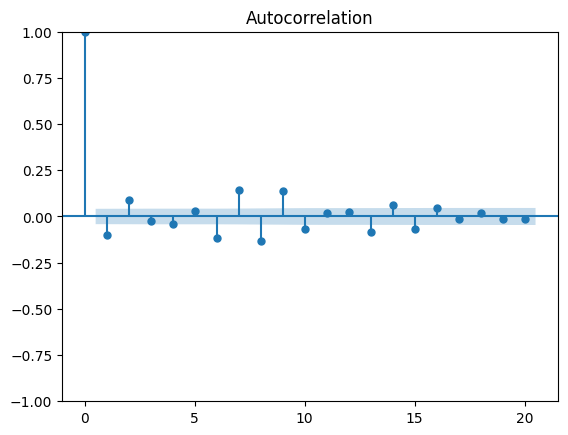

In [44]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(returns, lags=20)
plt.show()

<h5>

- From the plot above, in 12/20 days, the autocorrelation is too largge to be random and the value would be very unlikely if H0 were true. Hence, we reject H0 as the data is statistically significant.

- Meanwhile, in 8/20 days, the bar stays in the band. The estimated autocorrelation is small and the value is plausible under H0. Hence, the data does not contradict the null and is not statistically significant.

- Overall, it seems like autocorrelation is present has an AR (Autoregressive) /ARMA (Autoregressive Moving Average) model is needed.

<h3> Volatility Clustering - ARCH test

- ARCH idea: even if returns are uncorrelated, squared returns are correlated

ARCH test checks whether: Var(r(t)|F(t-1)) =/= constant

<h5>

- h0: no volatility clustering
- To justify GARCH-based VaR

In [29]:
from statsmodels.stats.diagnostic import het_arch

arch_stat, arch_p, _, _ = het_arch(returns)
print(f"ARCH test results: ARCH Statistic = {arch_stat:.4f}, p-value = {arch_p:.4f}")

ARCH test results: ARCH Statistic = 896.3543, p-value = 0.0000


<h5> From the ARCH test results above, as p-value = 0.00 < 0.05, since p-value is statistically significant we strongly reject the null hypothesis that there is no volatility clustering and conclude that volatility is time-varying.
<br><br>
In industry, this justifies the use of GARCH (Generalized ARCH - More flexible and realistic).

<h3> Overall conclusion for Assumption Testing

<h4>

- Assumption testing indicates strong departures from normality and constant volatility. 
- The Jarque–Bera test strongly rejects normality, consistent with fat-tailed financial returns. 
- Autocorrelation analysis suggests linear dependence in returns, supporting the use of AR/ARMA models. 
- Furthermore, the ARCH test reveals significant volatility clustering, indicating time-varying risk dynamics and motivating the use of conditional volatility models such as GARCH for risk estimation.